# KCCA Tutorial

In [2]:
%matplotlib inline
import numpy as np
import sys
sys.path.append("../../..")
from mvlearn.embed.kcca import KCCA
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'graspy'

In [3]:
import graspy

ModuleNotFoundError: No module named 'graspy'

In [2]:
def make_data(kernel, N):
    # # # Define two latent variables (number of samples x 1)
    latvar1 = np.random.randn(N,)
    latvar2 = np.random.randn(N,)
    
    # # # Define independent components for each dataset (number of observations x dataset dimensions)
    indep1 = np.random.randn(N, 4)
    indep2 = np.random.randn(N, 5)
    
    if kernel == "linear":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "poly":
        x = 0.25*indep1 + 0.75*np.vstack((latvar1**2, latvar2**2, latvar1**2, latvar2**2)).T
        y = 0.25*indep2 + 0.75*np.vstack((latvar1, latvar2, latvar1, latvar2, latvar1)).T
        
        return [x,y]
    
    elif kernel == "gaussian":
        t = np.random.uniform(-np.pi, np.pi, N)
        e1 = np.random.normal(0, 0.05, (N,2))
        e2 = np.random.normal(0, 0.05, (N,2))
        
        x = np.zeros((N,2))
        x[:,0] = t
        x[:,1] = np.sin(3*t)
        x += e1
        
        y = np.zeros((N,2))
        y[:,0] = np.exp(t/4)*np.cos(2*t)
        y[:,1] = np.exp(t/4)*np.sin(2*t)
        y += e2
        
        return [x,y]

# Linear kernel implementation

In [32]:
Xs = make_data('linear', 100)
kcca_l = KCCA(ktype ="linear", constant = 100.0, n_components = 4)
linearkcca = kcca_l.fit_transform(Xs)
weights = linearkcca.weights_
components = linearkcca.components_

([], <a list of 0 Text yticklabel objects>)

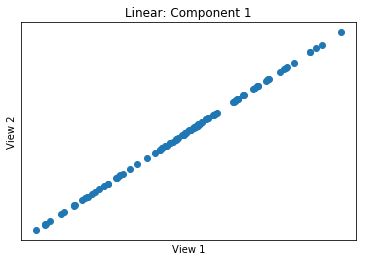

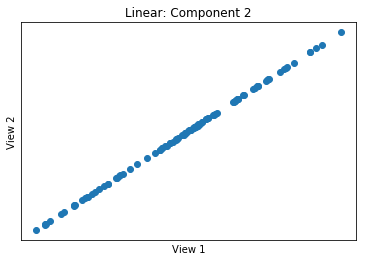

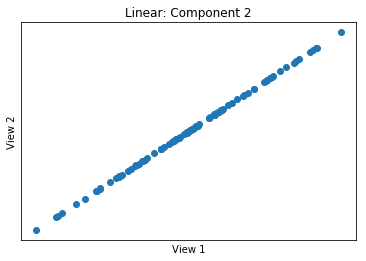

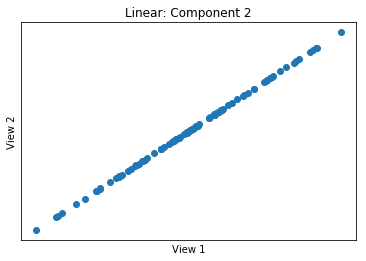

In [35]:
fig = plt.figure()
plt.scatter(components[0][0], components[1][0])
plt.title('Linear: Component 1')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(components[0][1], components[1][1])
plt.title('Linear: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(components[0][2], components[1][2])
plt.title('Linear: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(components[0][3], components[1][3])
plt.title('Linear: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

# Polynomial kernel implementation

In [23]:
Xsp = make_data("poly", 100)
kcca_p = KCCA(ktype ="poly", constant = 100.0, degree = 2.0, n_components = 2)
polykcca = kcca_p.fit_transform(Xsp)
weightsp = polykcca.weights_
componentsp = polykcca.components_

([], <a list of 0 Text yticklabel objects>)

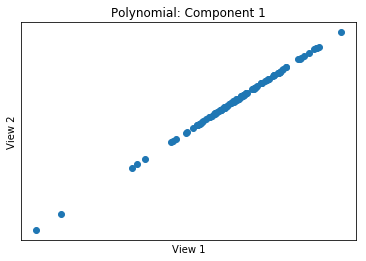

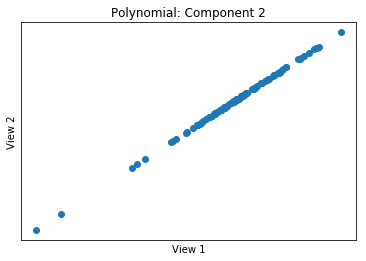

In [24]:
fig = plt.figure()
plt.scatter(componentsp[0][0], componentsp[1][0])
plt.title('Polynomial: Component 1')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(componentsp[0][1], componentsp[1][1])
plt.title('Polynomial: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

# Gaussian Kernel Implementation

In [30]:
Xsg = make_data("gaussian", 100)
kcca_g = KCCA(ktype ="gaussian", sigma = 3.0, n_components = 2)
gausskcca = kcca_g.fit_transform(Xsg)
weightsg = gausskcca.weights_
componentsg = gausskcca.components_

([], <a list of 0 Text yticklabel objects>)

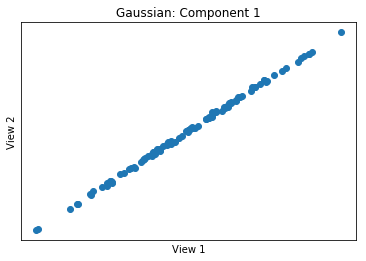

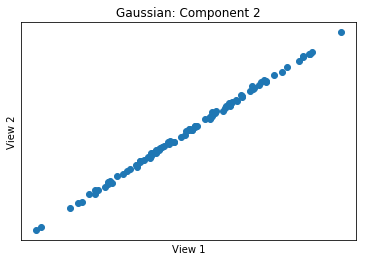

In [31]:
fig = plt.figure()
plt.scatter(componentsg[0][0], componentsg[1][0])
plt.title('Gaussian: Component 1')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])

fig = plt.figure()
plt.scatter(componentsg[0][1], componentsg[1][1])
plt.title('Gaussian: Component 2')
plt.xlabel('View 1')
plt.ylabel('View 2')
plt.xticks([])
plt.yticks([])